<a href="https://colab.research.google.com/github/Rohit9403/Art-Generation-using-Transfer-Learning/blob/master/Art_Generation_using_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Goal
The goal of this journey is to setup an optimisation problem that aims to solve for a combination image that contains the content of the content image, while having the style of the style image.

#Dependencies

In [0]:
import numpy as np
from keras.applications import vgg16
from keras import backend 
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image 
import time
from scipy.optimize import fmin_l_bfgs_b


#Load Image And Preprocess the content


We need to load and Resize the image according to our input to the VGG16 Network

Content image

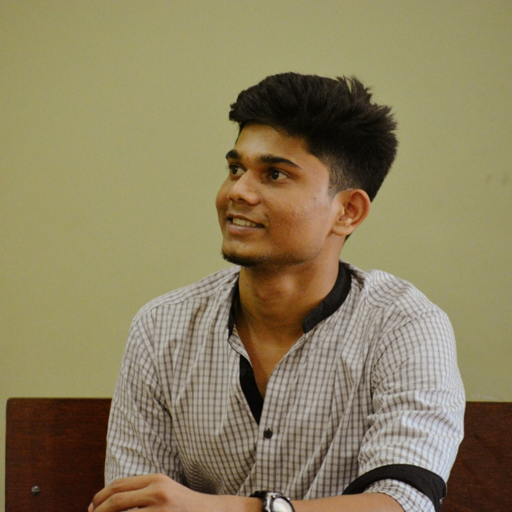

In [4]:
height = 512
width = 512

content_image_path = '/content/Rohit 1.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

Style Image

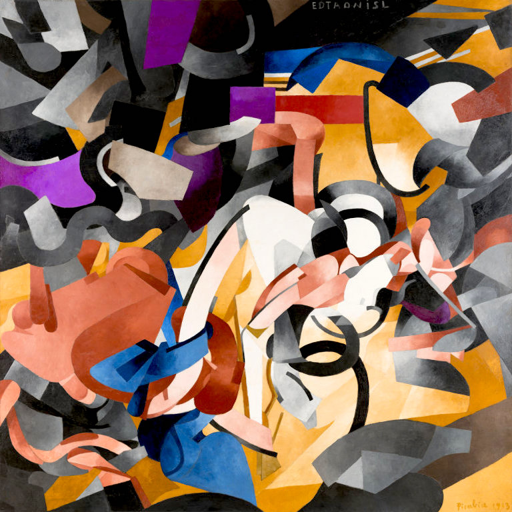

In [5]:
style_image_path = '/content/ART 0.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

#Convert Image into 3D tensor

We need to convert the image into a 3D tensor of array with datatype "Float"

We add another dimension (To make it height*width*3rd dimension) bcz we need to concatenate the representations of these two images into a common data structure.

In [6]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


#VGG network Preprocessing

We need to make input data which is suitable as input for VGG 16 network
as given in the following 
[link text](https://arxiv.org/abs/1409.1556)

For this we need to perform Two transformations


1.   Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.
2.   Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).



In [0]:
content_array[:, :, :, 0] -= 103.939# Values obtaimned from google search
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1] #Flip the array from RGB to BGR

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]


These arrays are now ready to use for Keras backend



Placeholder variable is used to store combination image that retains the content of the content image while incorporating the style of the style image.

In [8]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Concatenate all this image data into single tensor 

In [0]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

#VGG16 Netwwork Usage


we’re not interested in the classification problem, we don’t need the fully-connected layers or the final softmax classifier.

Note that by setting include_top=False in the code below, we don’t include any of the fully-connected layers.

Weights are being trained on 'imagnet' for VGG16 networks

In [10]:
model =vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
print('Model loaded')




58892288/58889256 [==============================] - 6s 0us/step






Model loaded


As model has lot of layers but it has its own names for these layers 

Get list of all the layers 

In [11]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

#The LOSS

The loss function can be decomposed into Three distinct parts




1.   Content loss
2.   Style loss
3.   Total variation loss

















The relative importance of these losses are deteremined by scalar wwights.

Note: These weights are found after certain Experimentation. U can take arbitrary values according to ur choices.

In [0]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0
loss = backend.variable(0.)

Initializing the Loss to 0 and adding it to in stages



In [0]:
loss = backend.variable(0.)

Why layer "block2_conv2" only?

layer "block2_conv2" can retain the structure of faces from the original layers. In our case i have used the content image as a Face image we can use this layer.



**Content Loss**


The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [14]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

**Style Loss**




**Gram matrix**

captures information about which features tend to activate together.

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

So,

Style loss= Combination Images - Gram Matrices

In [0]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

#The total variation loss

You can experiment with reducing the total_variation_weight and play with the noise-level of the generated image.

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

#Define needed gradients and solve the optimisation problem

We define gradients of the total loss relative to the combination image, and use these gradients to iteratively improve upon our combination image to minimise the loss.

In [18]:
grads = backend.gradients(loss, combination_image)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We then introduce an Evaluator class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads. This is done because scipy.optimize requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

U can choose ur Own Number of iterations according to ur output

In [20]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 138782690000.0
Iteration 0 completed in 16s
Start of iteration 1
Current loss value: 72312594000.0
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 54745395000.0
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 46410584000.0
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 41569866000.0
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 38642307000.0
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 36578406000.0
Iteration 6 completed in 6s
Start of iteration 7
Current loss value: 35114086000.0
Iteration 7 completed in 6s
Start of iteration 8
Current loss value: 34228517000.0
Iteration 8 completed in 6s
Start of iteration 9
Current loss value: 33581343000.0
Iteration 9 completed in 6s


we need to subject our output image to the inverse of the transformation we did to our input images before it makes sense.

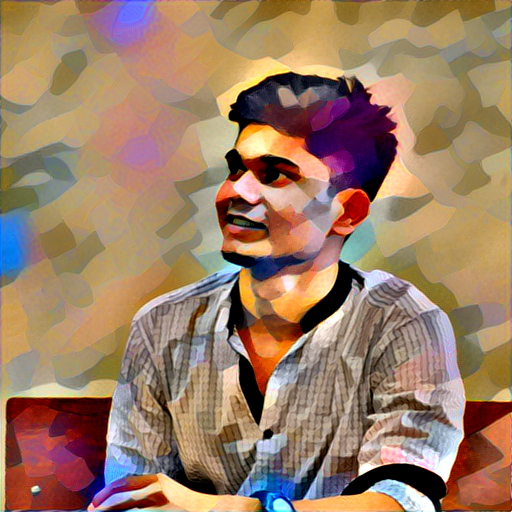

In [21]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)